In [133]:
#!pip install /kaggle/input/dicomsdl-offline-installer/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
!pip install --no-deps /kaggle/input/keras-cv-attention-models/keras_cv_attention_models-1.3.9-py3-none-any.whl

Processing /kaggle/input/keras-cv-attention-models/keras_cv_attention_models-1.3.9-py3-none-any.whl
keras-cv-attention-models is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


!cp /kaggle/input/train-df/gdcm.tar .
!tar -xvzf gdcm.tar
!conda install --offline ./gdcm/gdcm-2.8.9-py37h71b2a6d_0.tar.bz2
import pydicom

In [134]:
import os
import random
import time
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import math

from enum import Enum
import matplotlib.pyplot as plt

import tensorflow as tf

from joblib import Parallel, delayed

In [135]:
SEED = 2061986
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [136]:
#df = pd.DataFrame({"trainSetLen":50876, "validSetLen":3830, "imageWidth":[256], "imageHeight":256,'TrainSet':'full', 'imageFormat':'JPG'})
df = pd.read_csv('/kaggle/input/tfr-breast-dataset/image_conf.csv')

#datas from prepareSet
trainSetLen = df.iloc[0]['trainSetLen']
trainSetPositive = df.iloc[0]['trainSetPositive']
validSetLen = df.iloc[0]['validSetLen']
img_shape = (df.iloc[0]['imageWidth'],df.iloc[0]['imageHeight'])
TRAIN_SETS=df.iloc[0]['trainSets']
IMAGE_FORMAT = df.iloc[0]['imageFormat']
#IMAGE_FORMAT = 'JPG'
if TRAIN_SETS is None or TRAIN_SETS==0:
    TRAIN_SETS='full'

print(f'Train set is {trainSetLen}\n' +
    f'Train set Positive {trainSetPositive}\n' + 
    f'Validation set is {validSetLen}\n' +
    f'ImageShape {img_shape}\n'+
    f'Train Set is {TRAIN_SETS}\n')

Train set is 40645
Train set Positive 1029
Validation set is 4517
ImageShape (768, 1344)
Train Set is 38



In [137]:
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on CPU or GPU')
    TPU = None
    
if TPU:
    IS_TPU = True
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    STRATEGY = tf.distribute.experimental.TPUStrategy(TPU)
else:
    IS_TPU = False
    STRATEGY = tf.distribute.MirroredStrategy()


policy = tf.keras.mixed_precision.Policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)


Running on TPU  grpc://10.0.0.2:8470


In [138]:
N_REPLICAS = STRATEGY.num_replicas_in_sync
LR_MAX = 3e-6 * N_REPLICAS
#LR_MAX = 1e-5
WD_RATIO = 0.1
BATCH_SIZE = 8 * N_REPLICAS
N_EPOCHS = 12


print(f'N_REPLICAS: {N_REPLICAS}, IS_TPU: {IS_TPU}')

N_REPLICAS: 8, IS_TPU: True


**DataGenerator for Keras tpu model**

In [139]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)

In [140]:
from kaggle_datasets import KaggleDatasets
if TPU:
    GCS_DS_PATH = KaggleDatasets().get_gcs_path('tfr-breast-dataset')
else:
    GCS_DS_PATH = '/kaggle/input/tfr-breast-dataset'


In [141]:
def augment_image(X, y):
    image = X['image_input']
    
    # Random Brightness
    image = tf.image.random_brightness(image, 0.10)
    
    # Random Contrast
    image = tf.image.random_contrast(image, 0.90, 1.10)
    
    # Random JPEG Quality
    image = tf.image.random_jpeg_quality(image, 75, 100)
    
    # Random crop image with maximum of 10%
    ratio = tf.random.uniform([], 0.75, 1.00)
    img_height_crop = tf.cast(ratio * img_shape[1], tf.int32)
    img_width_crop = tf.cast(ratio * img_shape[0], tf.int32)
    # Random offset for crop
    img_height_offset = tf.random.uniform([], minval=0, maxval=(img_shape[1] - img_height_crop),dtype=tf.int32)
    img_width_offset = 0
    # Crop And Resize
    image = tf.slice(image, [img_height_offset, img_width_offset, 0], [img_height_crop, img_width_crop, N_CHANELS])
    image = tf.image.resize(image, [img_shape[1], img_shape[0]], method=tf.image.ResizeMethod.BILINEAR)
    # Clip pixel values in range [0,255] to prevent underflow/overflow
   
        
    return { 'image_input': image, 'age_input':X['age_input'] }, y

def undersample_majority(X, y):
    # Filter 2/5
    return y == 1 or tf.random.uniform([]) > 0.4

In [142]:

AUTO = tf.data.experimental.AUTOTUNE
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False
N_CHANELS = 1

def decode_image(record_bytes):
    features = tf.io.parse_single_example(record_bytes, {
        'image': tf.io.FixedLenFeature([], tf.string),
        'age_imp': tf.io.FixedLenFeature([2], tf.float32),
        'target': tf.io.FixedLenFeature([], tf.float32),
    })
    
    if IMAGE_FORMAT == 'PNG':
        image = tf.io.decode_png(features['image'], channels=N_CHANELS)
    else:
        image = tf.io.decode_jpeg(features['image'], channels=N_CHANELS)

    
    image = tf.reshape(image, [img_shape[1], img_shape[0], N_CHANELS])
    image = tf.cast(image, tf.float32)
    image = tf.math.divide(image, tf.reduce_max(image))
    
   
    target = features['target']
    age_impl = features['age_imp']
    #age_impl = age_impl[0]
    
    return {"image_input": image,"age_input":age_impl}, target
    #return {"image_input": image,"age_input":age }, target


In [143]:
def createDataset(files, valid=False):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    
    dataset = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO, compression_type='GZIP')
    
    dataset = dataset.map(decode_image, num_parallel_calls=AUTO)

    dataset = dataset.with_options(ignore_order)
    if not valid:
        dataset = dataset.filter(undersample_majority)
        dataset = dataset.map(augment_image, num_parallel_calls=AUTO)
        dataset = dataset.with_options(ignore_order)
        dataset = dataset.shuffle(2048, seed=43, reshuffle_each_iteration=True)
        dataset = dataset.repeat()
    # Batch samples
    dataset = dataset.batch(BATCH_SIZE,  drop_remainder=not valid)
    dataset = dataset.prefetch(AUTO)
    return dataset


trainFiles = sorted(tf.io.gfile.glob(f'{GCS_DS_PATH}/nn_train*.tfrecords'))
validFiles = sorted(tf.io.gfile.glob(f'{GCS_DS_PATH}/nn_val*.tfrecords'))

evaluteFiles = validFiles[-1:]
validFiles = validFiles[:-1] 

N_SAMPLES_TFRECORDS = 1024
TRAIN_TFRECORDS = len(trainFiles)
TRAIN_STEPS_PER_EPOCH = trainSetLen // BATCH_SIZE + 1
#TRAIN_STEPS_PER_EPOCH = TRAIN_TFRECORDS *  N_SAMPLES_TFRECORDS // BATCH_SIZE
VALID_TFRECORDS = len(validFiles)
EVAL_TFRECORDS = len(evaluteFiles)
#VALID_STEPS_PER_EPOCH = (validSetLen -(EVAL_TFRECORDS*N_SAMPLES_TFRECORDS))  // BATCH_SIZE + 1
VALID_STEPS_PER_EPOCH = VALID_TFRECORDS * N_SAMPLES_TFRECORDS // BATCH_SIZE

#EVAL_STEPS = (EVAL_TFRECORDS *N_SAMPLES_TFRECORDS ) // BATCH_SIZE 
EVAL_STEPS = (validSetLen - VALID_TFRECORDS * N_SAMPLES_TFRECORDS) // BATCH_SIZE+1

trainSet = createDataset(trainFiles)
validSet = createDataset(validFiles, True)

In [144]:
print(f"Train steps: {TRAIN_STEPS_PER_EPOCH}, valid steps: {VALID_STEPS_PER_EPOCH}, eval steps:{EVAL_STEPS}")

Train steps: 636, valid steps: 64, eval steps:7


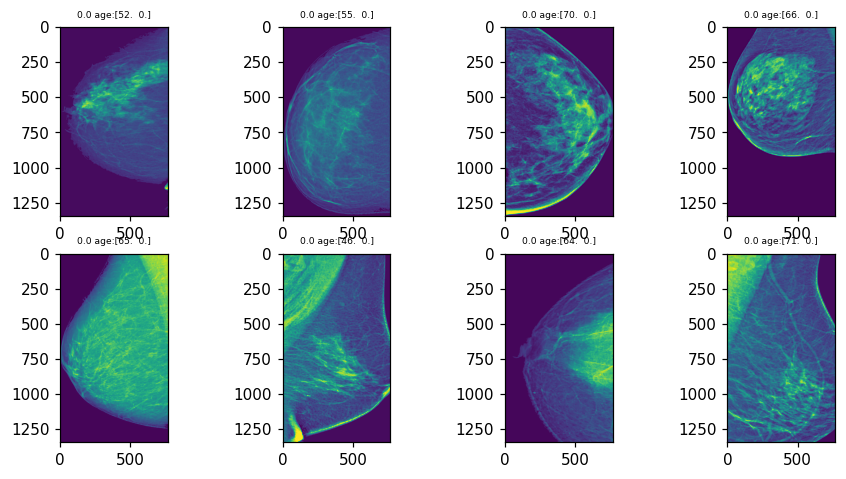

In [145]:
plt.figure(figsize=(10,5),dpi=110)
for images, target in iter(createDataset(trainFiles)):
    image = images['image_input']
    age = images['age_input']

    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.title(f'{target[i]} age:{age[i]}',fontsize=6)
        plt.imshow(image[i])

    break
    

# **KERAS simple model**

In [146]:
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Input
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import LayerNormalization, Concatenate, Dropout
from tensorflow.keras.layers import Add, Multiply, Average, Maximum
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras_cv_attention_models import convnext,resnet_family

In [147]:
class pFBeta(tf.keras.metrics.Metric):
    def __init__(self, beta=1, name='pF1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.beta = beta
        self.epsilon = 1e-10
        self.pos = self.add_weight(name='pos', initializer='zeros')
        self.ctp = self.add_weight(name='ctp', initializer='zeros')
        self.cfp = self.add_weight(name='cfp', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 0, 1)
        pos = tf.cast(tf.reduce_sum(y_true), tf.float32)
        ctp = tf.cast(tf.reduce_sum(y_pred[y_true == 1]), tf.float32)
        cfp = tf.cast(tf.reduce_sum(y_pred[y_true == 0]), tf.float32)
        self.pos.assign_add(pos)
        self.ctp.assign_add(ctp)
        self.cfp.assign_add(cfp)
        
    def result(self):
        beta2 = self.beta * self.beta
        prec = self.ctp / (self.ctp + self.cfp + self.epsilon)
        reca = self.ctp / (self.pos + self.epsilon)
        return (1 + beta2) * prec * reca / (beta2 * prec + reca)
        
    def reset_state(self):
        self.pos.assign(0.)
        self.ctp.assign(0.)
        self.cfp.assign(0.)

In [148]:
model_name = f'n_model_{img_shape[0]}_{img_shape[1]}_convnext_ff_ss{TRAIN_SETS}_noflip_04_ep{N_EPOCHS}.h5'
print(model_name)
print(f"LR_MAX : {LR_MAX}, WD_RATION: {WD_RATIO}")

def getModel():
    
    input_image = Input(shape=(img_shape[1],img_shape[0],1),name="image_input")
    
    prepare_image = tf.repeat(input_image, repeats=3, axis=3)
    
    
    cnn = convnext.ConvNeXtV2Tiny(input_shape=(img_shape[1], img_shape[0],3), pretrained='imagenet21k-ft1k',num_classes=0)(prepare_image)
    """
    cnn = resnet_family.ResNeXt50(input_shape=(img_shape[1], img_shape[0],3), 
                                   pretrained='swsl',
                                   num_classes=0)(prepare_image)
    """

    final_layer = GlobalAveragePooling2D()(cnn)
   
    age = Input(shape=(2,),name='age_input') #with implants
    final_layer = Concatenate()([final_layer,age])
    
    
     #ff
    _final_layer = Dense(final_layer.shape[-1]*4,activation='elu', kernel_initializer='glorot_uniform', name='ff_1')(final_layer)
    _final_layer = Dropout(0.3)(_final_layer)
    _final_layer = Dense(final_layer.shape[-1],kernel_initializer='glorot_normal', name='ff_2' )(_final_layer)
    _final_layer = Dropout(0.3)(_final_layer)
    
    _final_layer = keras.activations.relu(_final_layer)
    final_layer = Add()([_final_layer,final_layer])
    final_layer = LayerNormalization(epsilon=1e-6)(final_layer)

    
    
    final_layer = Dense(1,activation='sigmoid')(final_layer)

    model = Model([input_image,age], final_layer)
 
    
    optimizer = tfa.optimizers.AdamW(
    learning_rate=LR_MAX,
    weight_decay=LR_MAX * WD_RATIO,
    epsilon=1e-7)
    
    
    if TPU:
        spe = 64
    else:
        spe = 1
    

# Loss
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    

    model.compile(optimizer=optimizer,
                  loss=loss,
                  steps_per_execution=spe,
                  metrics=[pFBeta(beta=1, name='pF1'),
                       tfa.metrics.F1Score(num_classes=1, threshold=0.50, name='F1'),
                       tf.metrics.AUC(name='AUC'),
                       tf.metrics.BinaryAccuracy(name='BinAcc')])

    
    return model


n_model_768_1344_resnext_ff_ss38_noflip_ep12.h5
LR_MAX : 2.4e-05, WD_RATION: 0.1


In [149]:
tf.keras.backend.clear_session()
# enable XLA optmizations
tf.config.optimizer.set_jit(True)


with STRATEGY.scope():
    model = getModel()
    

model.summary()

115146752/115145456 [==============================] - 1s 0us/step
>>>> Load pretrained from: /root/.keras/models/convnext_v2_tiny_384_imagenet21k-ft1k.h5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 1344, 768, 1 0                                            
__________________________________________________________________________________________________
tf.repeat (TFOpLambda)          (None, 1344, 768, No 0           image_input[0][0]                
__________________________________________________________________________________________________
convnext_v2_tiny (Functional)   (None, 42, 24, 768)  27864960    tf.repeat[0][0]                  
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None,

In [150]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        return lr_max * 0.10 ** (num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

LR_SCHEDULE = [lrfn(step, num_warmup_steps=0, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)

In [151]:
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        #model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')
        #print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}')

In [152]:
checkpoint_filepath = f'best_{model_name}'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_pF1',
    mode='max',
    verbose=1,
    save_best_only=True)

In [153]:
Early=tf.keras.callbacks.EarlyStopping(
  monitor = "val_pF1",
  min_delta = 0.001,
  patience = 5,
  verbose = 1,
  mode = "max",
  restore_best_weights = True)

In [154]:
weight_for_0 = (1 / (trainSetLen-trainSetPositive)) * (trainSetLen / 2.0)
weight_for_1 = (1 / trainSetPositive) * (trainSetLen / 2.0)

class_weight = {0: 1, 1: 5}
#class_weight = {0: weight_for_0, 1: weight_for_1}
#class_weight = {0: 1, 1: weight_for_1}
class_weight

{0: 1, 1: 5}

In [155]:
_ = model.evaluate(
        createDataset(validFiles,True),
        steps=VALID_STEPS_PER_EPOCH,
    )


64/64 [==============================] - 34s 539ms/step - loss: 1.5635 - pF1: 0.0539 - F1: 0.0546 - AUC: 0.4684 - BinAcc: 0.0281


In [156]:

history = model.fit(trainSet, epochs = N_EPOCHS, steps_per_epoch = TRAIN_STEPS_PER_EPOCH,
         validation_data=validSet,
         validation_steps = VALID_STEPS_PER_EPOCH,
         callbacks = [lr_callback, WeightDecayCallback(), model_checkpoint,Early],
         class_weight=class_weight)


Epoch 1/12
learning rate: 2.40e-05, weight decay: 2.40e-06
636/636 [==============================] - 408s 641ms/step - loss: 0.5486 - pF1: 0.0775 - F1: 0.0175 - AUC: 0.5900 - BinAcc: 0.9530 - val_loss: 0.2153 - val_pF1: 0.0632 - val_F1: 0.0000e+00 - val_AUC: 0.7051 - val_BinAcc: 0.9714

Epoch 00001: val_pF1 improved from -inf to 0.06321, saving model to best_n_model_768_1344_resnext_ff_ss38_noflip_ep12.h5
Epoch 2/12
learning rate: 2.36e-05, weight decay: 2.40e-06
636/636 [==============================] - 310s 487ms/step - loss: 0.5168 - pF1: 0.0925 - F1: 0.0547 - AUC: 0.6707 - BinAcc: 0.9524 - val_loss: 0.1803 - val_pF1: 0.1048 - val_F1: 0.2286 - val_AUC: 0.8096 - val_BinAcc: 0.9670

Epoch 00002: val_pF1 improved from 0.06321 to 0.10483, saving model to best_n_model_768_1344_resnext_ff_ss38_noflip_ep12.h5
Epoch 3/12
learning rate: 2.24e-05, weight decay: 2.40e-06
636/636 [==============================] - 310s 487ms/step - loss: 0.4266 - pF1: 0.1632 - F1: 0.2922 - AUC: 0.8041 - BinAc

In [169]:
!cd working
!ls
!mv n_model_768_1344_resnext_ff_ss38_noflip_ep12.h5 n_model_768_1344_convnext_ff_ss38_noflip_ep12.h5

input  lib  working


In [157]:
model.save_weights(model_name)

In [158]:
_ = model.evaluate(
        createDataset(evaluteFiles,True),
        steps=EVAL_STEPS,
    )

7/7 [==============================] - 3s 439ms/step - loss: 0.0540 - pF1: 0.7182 - F1: 0.7333 - AUC: 0.9563 - BinAcc: 0.9810


In [159]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))
    
    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

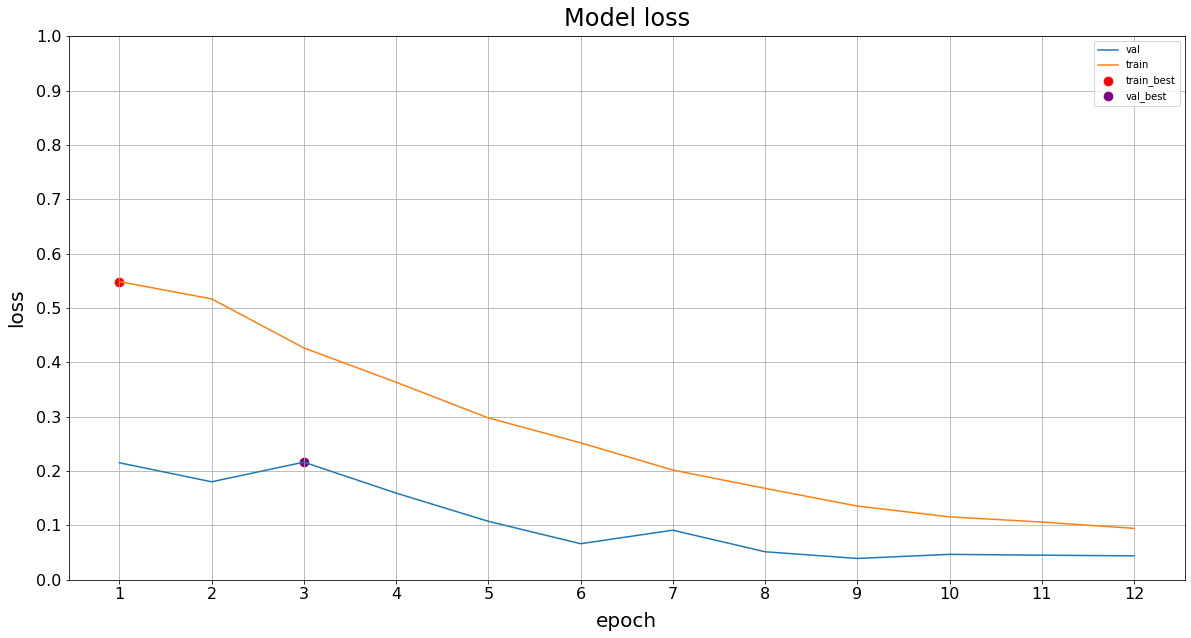

In [160]:
plot_history_metric('loss', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

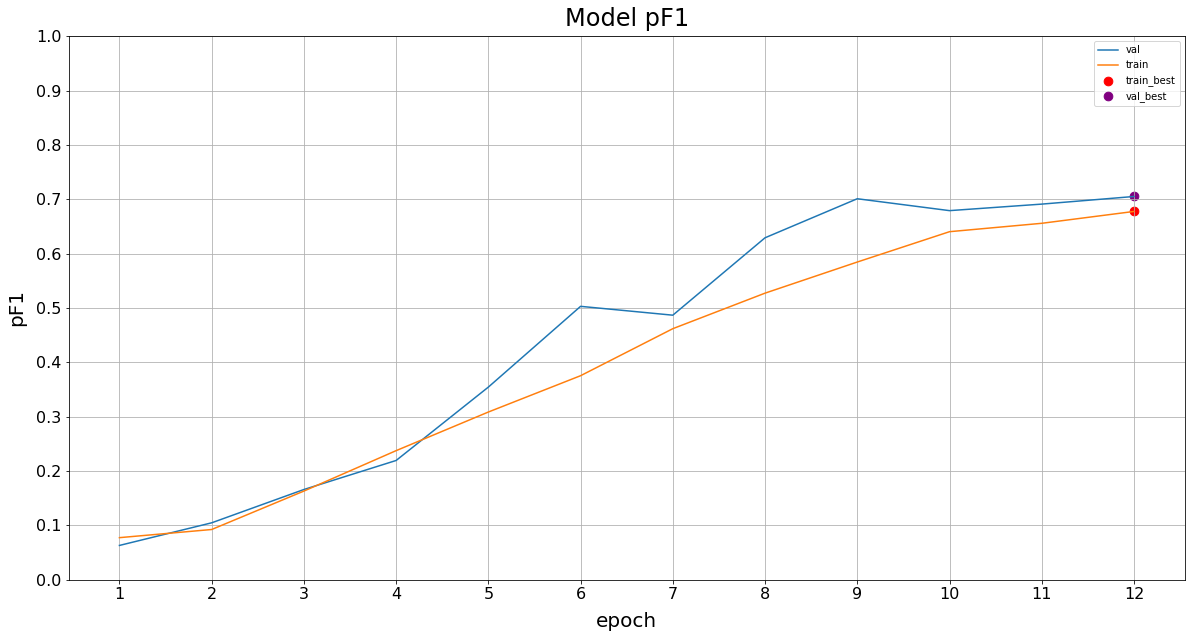

In [161]:
plot_history_metric('pF1', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))